In [35]:
%matplotlib widget

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import meshplot as mp
import wildmeshing as wm
plt.close('all')

In [37]:
def vec2(x,y):
    return np.array([x,y], dtype=np.float64)

def is_left(p0, p1, p2):
        return (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1])

def compute_signed_distance(poly, q):
    
    def is_left(p0, p1, p2):
        return (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1])

    N = poly.shape[0]
    d = np.inf

    # Compute distance to closest surface point
    for i in range(N-1):
        a = poly[i, :]    # Point on the surface of polygon p
        b = poly[i+1, :]  # Adjacent point on the surface of polygon p
        
        ba = b - a     # Vector from a to b
        bal = np.linalg.norm(ba) # Length of ba vector
        if bal == 0:
            continue
        ban = ba / bal # Normal of the vector from a to b
        qa = q - a     # The vector from the query point to a
        alpha = np.dot(qa, ban) / bal
        if alpha < 0:
            da = np.linalg.norm(q-a)
            if da < d:
                d = da
        elif alpha > 1:
            db = np.linalg.norm(q-b)
            if db < d:
                d = db
        else:
            banp = np.array([-ban[1], ban[0]])
            dp = abs(np.dot(qa, banp))
            if dp < d:
                d = dp
    # Compute winding number to set the sign
    wn = 0
    for i in range(N-1):
        a = poly[i, :]    # Point on the surface of polygon p
        b = poly[i+1, :]  # Adjacent point on the surface of polygon p
        if a[1] <= q[1]:
            if b[1] > q[1]:
                if is_left(a, b, q) > 0:
                    wn = wn + 1
        else:
            if b[1] <= q[1]:
                if is_left(a, b, q) < 0:
                    wn = wn -1
    if wn < -0.5:
        d = -d
    elif wn > 0.5:
        d = -d
    return d

def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I + 1)*(J + 1), 2), dtype=np.float64)
    for j in range(J + 1):
        for i in range(I + 1):
            k = i + j*(I + 1)
            V[k, 0] = x0 + i*dx
            V[k, 1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32) 
    for j in range(J):
        for i in range(I):
            k00 = (i    ) + (j    )*(I + 1)
            k01 = (i + 1) + (j    )*(I + 1)
            k10 = (i    ) + (j + 1)*(I + 1)
            k11 = (i + 1) + (j + 1)*(I + 1)
            e = 2*(i + j*I)
            if (i + j)%2:
                T[e    , :] = (k00, k01, k11)
                T[e + 1, :] = (k00, k11, k10)
            else:
                T[e    , :] = (k10, k00, k01)
                T[e + 1, :] = (k10, k01, k11)                    
    return V, T

In [38]:
class SimpleGrid2D:
    
    def __init__(self, min_coord, max_coord, I, J):
        if np.any(min_coord > max_coord):
            raise ValueError()
        if I < 2:
            raise ValueError()
        if J < 2:
            raise ValueError()

        self.min_coord = min_coord
        self.max_coord = max_coord
        
        self.I = I  # Number of nodes along x axis
        self.J = J  # Number of nodes along y axis
        
        res = np.array([I-1, J-1], dtype=np.float64)
        dims = (self.max_coord - self.min_coord)
        self.spacing = np.divide(dims, res)
        
        self.dx = self.spacing[0]
        self.dy = self.spacing[1]

        self.x = np.linspace(min_coord[0], max_coord[0], I)
        self.y = np.linspace(min_coord[1], max_coord[1], J)
    
        X, Y = np.meshgrid(self.x, self.y)
        self.X = X.T
        self.Y = Y.T
        self.values = np.zeros((I, J), dtype=np.float64)
        
    def interpolate(self, p):
        idx = np.floor((p - self.min_coord) / self.spacing)
        # if index is outside the cells then project onto closest cell
        i = np.clip(int(idx[0]), 0, self.I-2)
        j = np.clip(int(idx[1]), 0, self.J-2)
                
        x00 = self.values[i,j]
        x01 = self.values[i+1,j]
        x10 = self.values[i,j+1]
        x11 = self.values[i+1,j+1]
        
        s = (p[0]  - (i * self.spacing[0] + self.min_coord[0]) ) / self.spacing[0]
        t = (p[1]  - (j * self.spacing[1] + self.min_coord[1])) / self.spacing[1]        

        y0 = (x01 - x00) * s + x00
        y1 = (x11 - x10) * s + x10
        return (y1 - y0) * t + y0
    
    def eval_func(self, func):
        for i in range(self.I):
            for j in range(self.J):
                x = self.X[i,j]
                y = self.Y[i,j]
                self.values[i,j] = func(np.array([x, y]))

def calculate_stencil(points, grid):
        p0, p1, p2 = points
        bool0 = grid.interpolate(p0) < 0
        bool1 = grid.interpolate(p1) < 0
        bool2 = grid.interpolate(p2) < 0
        stencil = bool0 * 2**0 + bool1 * 2**1 + bool2 * 2**2
        return stencil

def find_intersection(p0, p1, grid):
    val0 = grid.interpolate(p0)
    val1 = grid.interpolate(p1)
    grad = (val1 - val0)/np.linalg.norm(p1 - p0)
    intersection = p0 + np.abs(val0/grad) * (p1 - p0)/np.linalg.norm(p1 - p0)
    return intersection

def permute(points, stencil, reverse = False):
    r = 1 if reverse else -1
    # CASE 0
    if stencil == 0:
        points_permuted = points
    # CASE 1
    elif stencil == 1:
        points_permuted = points
    # CASE 2
    elif stencil == 2:
        points_permuted = np.roll(points, 1 * r, axis=0)
    # CASE 3
    elif stencil == 3:
        points_permuted = points
    # CASE 4
    elif stencil == 4:
        points_permuted = np.roll(points, -1 * r, axis=0)
    # CASE 5
    elif stencil == 5:
        points_permuted = np.roll(points, -1 * r, axis=0)
    # CASE 6
    elif stencil == 6:
        points_permuted = np.roll(points, 1 * r, axis=0)
    # CASE 7
    elif stencil == 7:
        points_permuted = points
    return points_permuted

In [39]:
def one_inside_intersections(points, grid):
    p0, p_out1, p_out2 = points
    intersection1 = find_intersection(p0, p_out1, grid)
    intersection2 = find_intersection(p0, p_out2, grid)
    return p0, intersection1, intersection2

def one_inside_new_points(points, stencil, grid):
    points_permuted = permute(points, stencil, reverse=False)
    new_points = one_inside_intersections(points_permuted, grid)
    new_points_permuted = permute(new_points, stencil, reverse=True)
    return new_points_permuted

def one_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid):
    new_points = one_inside_new_points(points, stencil, grid)
    vertex_array[triangle_index_set] = new_points
    triangle_index_array = np.append(triangle_index_array, [triangle_index_set], axis=0)
    return vertex_array, triangle_index_array

In [40]:
def two_inside_intersections(points, grid):
    p0, p1, p_out = points
    intersection0 = find_intersection(p0, p_out, grid)
    intersection1 = find_intersection(p1, p_out, grid)
    return p0, p1, intersection0, intersection1

def two_inside_new_points(points, stencil, grid):
    points_permuted = permute(points, stencil, reverse=False)
    new_points = two_inside_intersections(points_permuted, grid)
    new_points_permuted = np.array([*permute(new_points[:3], stencil, reverse=True), new_points[3]])
    return new_points_permuted

def two_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid):
    new_points = two_inside_new_points(points, stencil, grid)
    
    vertex_array[triangle_index_set] = new_points[:3]
    # vertex_array = np.append(vertex_array, [new_points[3]], axis=0)
    
    # triangle_index_set_new = np.array([triangle_index_set[1], len(vertex_array) - 1, triangle_index_set[2]])
    triangle_index_array = np.append(triangle_index_array, [triangle_index_set], axis=0)
    # triangle_index_array = np.append(triangle_index_array, [triangle_index_set_new], axis=0)

    return vertex_array, triangle_index_array

In [41]:
def apply_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid):
    if stencil == 0:
        # No points inside
        vertex_array, triangle_index_array = vertex_array, triangle_index_array
    elif stencil == 1:
        # One point inside
        vertex_array, triangle_index_array = one_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 2:
        # One point inside
        vertex_array, triangle_index_array = one_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 3:
        # Two points inside
        vertex_array, triangle_index_array = two_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 4:
        # One point inside
        vertex_array, triangle_index_array = one_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 5:
        # Two points inside
        vertex_array, triangle_index_array = two_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 6:
        # Two points inside
        vertex_array, triangle_index_array = two_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 7:
        # All points inside
        triangle_index_array = np.append(triangle_index_array, triangle_index_set)
    triangle_index_array = triangle_index_array.reshape(-1, 3)
    return vertex_array, triangle_index_array

In [42]:
def marching_triangles(mesh, grid):
    V, T = mesh
    vertex_array = V.copy()
    triangle_index_array = np.array([], dtype=np.int32)
    for triangle_index_set in T:
        points = V[triangle_index_set]
        
        stencil = calculate_stencil(points, grid)
        vertex_array, triangle_index_array = apply_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    return vertex_array, triangle_index_array

def make_mt_mesh(poly, I, J):
    min_coord = vec2(min(poly[:,0]), min(poly[:,1]))*1.2
    max_coord = vec2(max(poly[:,0]), max(poly[:,1]))*1.2
    width = (max_coord[0] - min_coord[0])
    height = (max_coord[1] - min_coord[1])
    V, T = make_beam_mesh(width, height, (I, J))
    grid = SimpleGrid2D(min_coord, max_coord, I, J)
    grid.eval_func(lambda p: compute_signed_distance(poly, p))


    ##### RUN THE MARCHING TRIANGLES ALGORITHM #####
    vertex_array, triangle_index_array = marching_triangles((V, T), grid)
    return vertex_array, triangle_index_array

In [43]:
def make_wm_mesh(polygon, segments):
    X = polygon[:,0]
    Y = polygon[:,1]
    K = segments
    P = np.zeros((K,2))
    P[:,0] = X
    P[:,1] = Y
    L = np.array([(k,(k+1)%K) for k in range(K)],dtype=np.int32)
    V, T, _, _ = wm.triangulate_data(P, L, cut_outside=True)
    return (V, T)

In [44]:
import numpy as np

def calculate_tetrahedron_volume(v0, v1, v2, v3):
    # Calculate the vectors
    v01 = v1 - v0
    v02 = v2 - v0
    v03 = v3 - v0
    
    # Calculate the cross product
    cross_product = np.cross(v02, v03)
    
    # Calculate the dot product
    dot_product = np.dot(v01, cross_product)
    
    # Calculate the absolute value and divide by 6
    volume = abs(dot_product) / 6
    
    return volume

In [45]:
def compute_signed_volume(pi, pj, pk, pm):
    return np.dot((pm - pi), np.cross((pj - pi), (pk - pi))) / 6.0

def compute_signed_area(pi, pj, pk):
    return 0.5 * np.linalg.norm(np.cross((pj - pi), (pk - pi)))
    
def compute_circumscribed_sphere(p0, p1, p2, p3):
    A = p0 - p3
    B = p1 - p3
    C = p2 - p3

    M00 = np.dot(A, A)
    M01 = np.dot(A, B)
    M02 = np.dot(A, C)
    M10 = np.dot(B, A)
    M11 = np.dot(B, B)
    M12 = np.dot(B, C)
    M20 = np.dot(C, A)
    M21 = np.dot(C, B)
    M22 = np.dot(C, C)

    M = np.array([[M00, M01, M02], [M10, M11, M12], [M20, M21, M22]], dtype=np.float64)
    q = 0.5 * np.array([M00, M11, M22], dtype=np.float64)
    
    u = np.linalg.lstsq(M, q, rcond=None)[0]

    u0 = u[0]
    u1 = u[1]
    u2 = u[2]
    u3 = 1.0 - u0 - u1 - u2

    radius = np.linalg.norm(u0 * A + u1 * B + u2 * C)
    center = u0 * p0 + u1 * p1 + u2 * p2 + u3 * p3

    return center, radius

def compute_inscribed_sphere(pi, pj, pk, pm):
    nm = np.cross((pj - pi), (pk - pi))
    ni = np.cross((pm - pj), (pk - pj))
    nj = np.cross((pm - pk), (pi - pk))
    nk = np.cross((pm - pi), (pj - pi))
    Lnm = np.linalg.norm(nm)
    Lni = np.linalg.norm(ni)
    Lnj = np.linalg.norm(nj)
    Lnk = np.linalg.norm(nk)
    nm = nm / Lnm
    ni = ni / Lni
    nj = nj / Lnj
    nk = nk / Lnk

    wm = np.dot(nm, pi)
    wi = np.dot(ni, pj)
    wj = np.dot(nj, pk)
    wk = np.dot(nk, pi)

    M00 = nm[0]
    M01 = nm[1]
    M02 = nm[2]
    M03 = -1.0

    M10 = ni[0]
    M11 = ni[1]
    M12 = ni[2]
    M13 = -1.0

    M20 = nj[0]
    M21 = nj[1]
    M22 = nj[2]
    M23 = -1.0

    M30 = nk[0]
    M31 = nk[1]
    M32 = nk[2]
    M33 = -1.0

    A = np.array([[M00, M01, M02, M03], [M10, M11, M12, M13], [M20, M21, M22, M23], [M30, M31, M32, M33]],
                 dtype=np.float64)
    b = np.array([wm, wi, wj, wk], dtype=np.float64)

    x = np.linalg.lstsq(A, b, rcond=None)[0]

    center = np.array( [x[0], x[1], x[2]], dtype=np.float64)
    radius = x[3]

    return center, radius

def compute_inscribed_circle(pi, pj, pk):
    a = np.linalg.norm(pj - pk)
    b = np.linalg.norm(pi - pk)
    c = np.linalg.norm(pi - pj)
    s = 0.5 * (a + b + c)
    center = (a * pi + b * pj + c * pk) / (a + b + c)
    radius = np.sqrt((s - a) * (s - b) * (s - c) / s)
    return center, radius

def compute_circumscribed_circle(p0, p1, p2):
    p3 = p0
    center, radius = compute_circumscribed_sphere(p0, p1, p2, p3)
    return center, radius

def compute_rms_edge_length(points):
    norm_array = np.linalg.norm(points[:, np.newaxis] - points, axis=2)
    norm_array_squared = np.square(norm_array)
    norm_array_square_triu = np.triu(norm_array_squared, k=1)
    num_edges = np.sum(np.triu(norm_array_squared, k=1) > 0)
    l_rms_squared = np.sum(norm_array_square_triu)/num_edges
    l_rms = np.sqrt(l_rms_squared)
    return l_rms

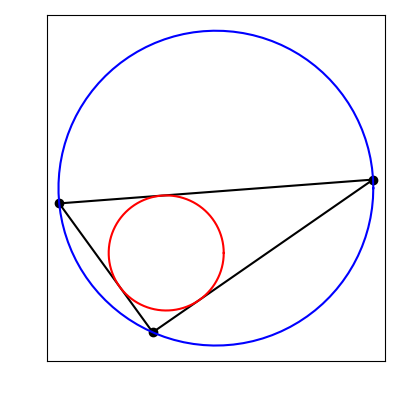

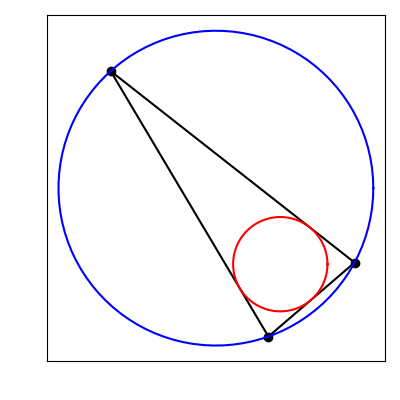

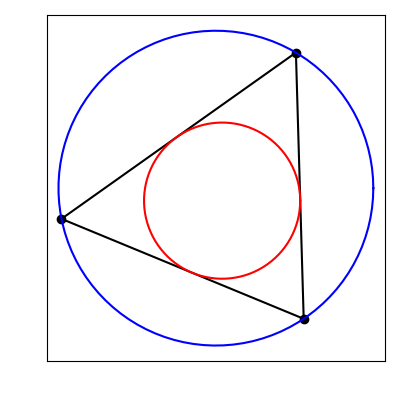

In [53]:
triangles = np.array([[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]], dtype=np.int32)
for i in range(3):
    x0 = np.random.rand(2)
    x1 = np.random.rand(2)
    x2 = np.random.rand(2)

    points = np.array([x0, x1, x2], dtype=np.float64)
    fig = plt.figure(figsize=(4,4))
    plt.triplot(points[:,0], points[:,1], 'o-', color = 'black')

    circ_center, circ_radius = compute_circumscribed_circle(points[0], points[1], points[2])
    in_center, in_radius = compute_inscribed_circle(points[0], points[1], points[2])

    circ_points = np.array([])
    in_points = np.array([])

    for t in np.linspace(0, 2*np.pi, 100):
        circ_points = np.append(circ_points, [circ_center[0] + circ_radius*np.cos(t), circ_center[1] + circ_radius*np.sin(t)])
        in_points = np.append(in_points, [in_center[0] + in_radius*np.cos(t), in_center[1] + in_radius*np.sin(t)])
        
    # plt.plot(circ_center[0], circ_center[1], 'o', color = 'blue')
    plt.plot(circ_points[::2], circ_points[1::2], '-', color = 'blue', label = 'Circumscribed circle')

    # plt.plot(in_center[0], in_center[1], 'o', color = 'red')
    plt.plot(in_points[::2], in_points[1::2], '-', color = 'red', label = 'Inscribed circle')
    plt.tight_layout()
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    # plt.legend()
    plt.show()

In [47]:
def compute_tri_radius_ratio(pi, pj, pk):
    points = np.array([pi, pj, pk], dtype=np.float64)
    _, r_in = compute_inscribed_circle(*points)
    _, r_circ = compute_circumscribed_circle(*points)
    return 2 * r_in / r_circ

def compute_tri_area_ratio(pi, pj, pk):
    points = np.array([pi, pj, pk], dtype=np.float64)
    l_rms = compute_rms_edge_length(points)
    A = compute_signed_area(*points)
    return 4/3 * np.sqrt(3) * A / l_rms**2

def compute_tet_radius_ratio(pi, pj, pk, pm):
    points = np.array([pi, pj, pk, pm], dtype=np.float64)
    _, r_in = compute_inscribed_sphere(*points)
    _, r_circ = compute_circumscribed_sphere(*points)
    return 3 * r_in / r_circ

def compute_tet_volume_ratio(pi, pj, pk, pm):
    points = np.array([pi, pj, pk, pm], dtype=np.float64)
    l_rms = compute_rms_edge_length(points)
    V = np.abs(compute_signed_volume(*points))
    return 6 * np.sqrt(2) * V/l_rms**3

In [48]:
def plot_quality_histograms(V, T, quality_func, bins=25, figsize=(8,8)):
    points_array = V[T]
    Q = np.zeros(len(points_array), dtype=np.float64)
    for i, points in enumerate(points_array):
        Q[i] = quality_func(*points)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    hist = ax.hist(Q, bins=bins, color='black', edgecolor='white', linewidth=1.2)
    Q_mean = np.mean(Q)
    ax.set_xlim([0, 1.0])
    return fig, ax, hist, Q_mean

In [49]:
doExp1 = False
doExp2 = False
doExp3 = True
savefigs = True

In [50]:
### STAR MESHES AND QUALITIES ###

if doExp1:
    leg_nums = [5, 10, 20]
    for legs in leg_nums:
        points = 2*legs + 1

        title = f"{legs} legs"

        poly = np.zeros((points,2),dtype=np.float64)
        for i in range(points):
            r = 1
            if (i + 1) % 2 == 0:
                r = 1/3
            poly[i] = r * vec2(np.sin(2*np.pi*i/(points-1)), np.cos(2*np.pi*i/(points-1)))

        segments = len(poly)
        V_wm, T_wm = make_wm_mesh(poly, segments)
        
        fig, ax = plt.subplots(1, 1, figsize=(8,8))
        wm_title = f"{title} Wildmeshing"
        ax.set_title(wm_title)
        ax.set_aspect('equal')
        ax.triplot(V_wm[:,0], V_wm[:,1], T_wm, color = 'black')
        
        hfig1, hax1, hist1, Q1 = plot_quality_histograms(V_wm, T_wm, compute_tri_radius_ratio, bins=25)
        hfig2, hax2, hist2, Q2 = plot_quality_histograms(V_wm, T_wm, compute_tri_area_ratio, bins=25)
        wm_title1 = f"{wm_title}, radius ratio"
        wm_title2 = f"{wm_title}, area ratio"
        wm_titleQ1 = f"{wm_title1}, Q_mean = {Q1.round(2)}"
        wm_titleQ2 = f"{wm_title2}, Q_mean = {Q2.round(2)}"
        hax1.set_title(wm_titleQ1)
        hax2.set_title(wm_titleQ2)
        
        if savefigs:
            fig.savefig("Images/" + wm_title + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
            hfig1.savefig("Images/histograms/" + wm_title1 + " .png", dpi=300, bbox_inches='tight', pad_inches=0.1)
            hfig2.savefig("Images/histograms/" + wm_title2 + " .png", dpi=300, bbox_inches='tight', pad_inches=0.1)
        
        
        
        Is = [35, 100]
        for i, I in enumerate(Is):
            J = I
            V_mt, T_mt = make_mt_mesh(poly, I, J)
            fig, ax = plt.subplots(1, 1, figsize=(8,8))
            mt_title = f"{title} Marching Triangles with I = {I}"
            ax.set_title(mt_title)
            ax.set_aspect('equal')
            ax.triplot(V_mt[:,0], V_mt[:,1], T_mt, linewidth = 20/I, color='black')
            
            hfig1, hax1, hist1, Q1 = plot_quality_histograms(V_mt, T_mt, compute_tri_radius_ratio, bins=25)
            hfig2, hax2, hist2, Q2 = plot_quality_histograms(V_mt, T_mt, compute_tri_area_ratio, bins=25)
            mt_title1 = f"{mt_title}, radius ratio"
            mt_title2 = f"{mt_title}, area ratio"
            mt_titleQ1 = f"{mt_title1}, Q_mean = {Q1.round(2)}"
            mt_titleQ2 = f"{mt_title2}, Q_mean = {Q2.round(2)}"
            hax1.set_title(mt_titleQ1)
            hax2.set_title(mt_titleQ2)
            
            if savefigs:                
                fig.savefig("Images/" + mt_title + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
                hfig1.savefig("Images/histograms/" + mt_title1 + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
                hfig2.savefig("Images/histograms/" + mt_title2 + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
            print(f"Finished {mt_title}")

In [51]:
### LEFT BRAIN MESHES AND QUALITIES ###
if doExp2:
    ls = [0.05, 0.0125]
    for l_edge in ls:
        tetra = wm.Tetrahedralizer(stop_quality=500, edge_length_r = l_edge)
        tetra.load_mesh("left_brain.stl")
        tetra.tetrahedralize()
        V, T = tetra.get_tet_mesh()
        mp.plot(V, T, shading={"wireframe": True}, return_plot=True)
        hfig1, hax1, hist1, Q1 = plot_quality_histograms(V, T, compute_tet_radius_ratio, bins=25)
        hfig2, hax2, hist2, Q2 = plot_quality_histograms(V, T, compute_tet_volume_ratio, bins=25)
        
        title1 = f"Left brain, edge length = {l_edge}, radius ratio"
        titleQ1 = f"{title1}, Q_mean = {Q1.round(2)}"
        hax1.set_title(titleQ1)
        hax1.set_xlabel("Quality")
        hax1.set_ylabel("Frequency")
        
        title2 = f"Left brain, edge length = {l_edge}, volume ratio"
        titleQ2 = f"{title2}, Q_mean = {Q2.round(2)}"
        hax2.set_title(titleQ2)
        hax2.set_xlabel("Quality")
        hax2.set_ylabel("Frequency")
        
        if savefigs:
            hfig1.savefig("Images/histograms/" + title1 + ".png", dpi = 300, bbox_inches='tight', pad_inches=0.1)
            hfig2.savefig("Images/histograms/" + title2 + ".png", dpi = 300, bbox_inches='tight', pad_inches=0.1)
        print(f"Finished edge length {l_edge}")

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.015811…

Finished edge length 0.05


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.015972…

Finished edge length 0.0125


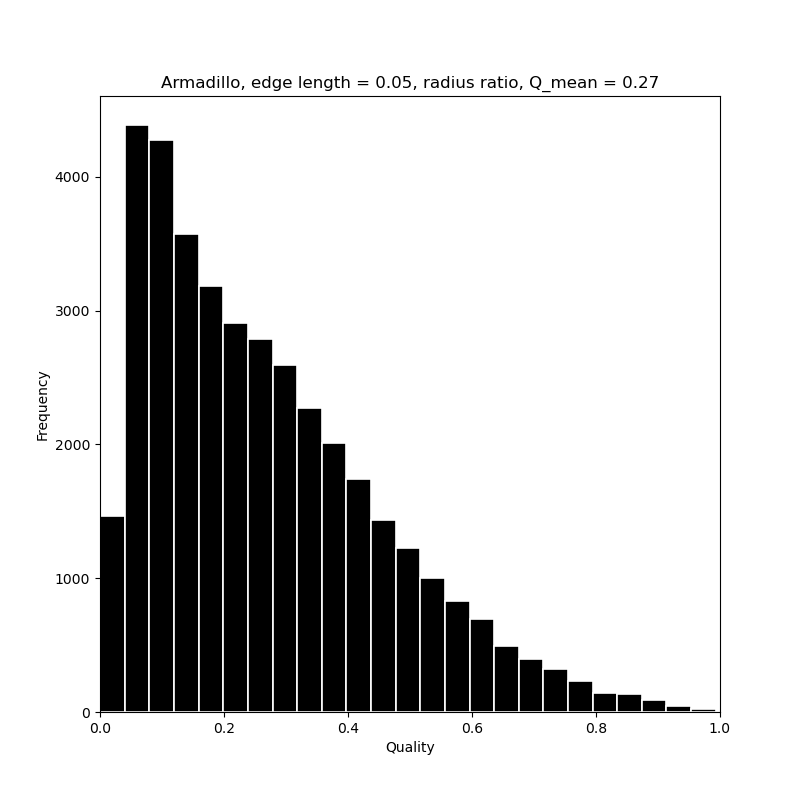

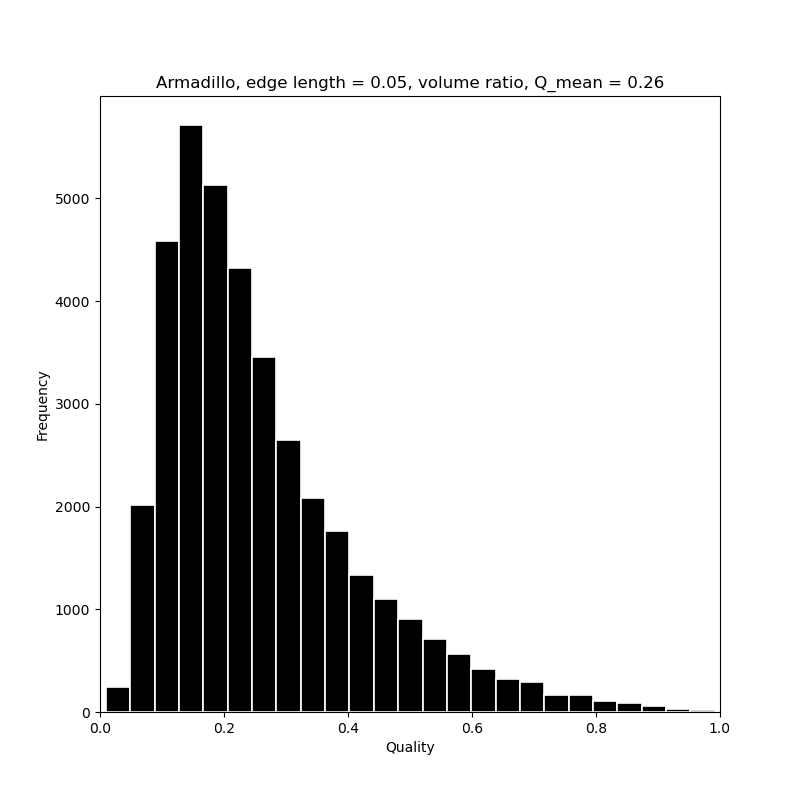

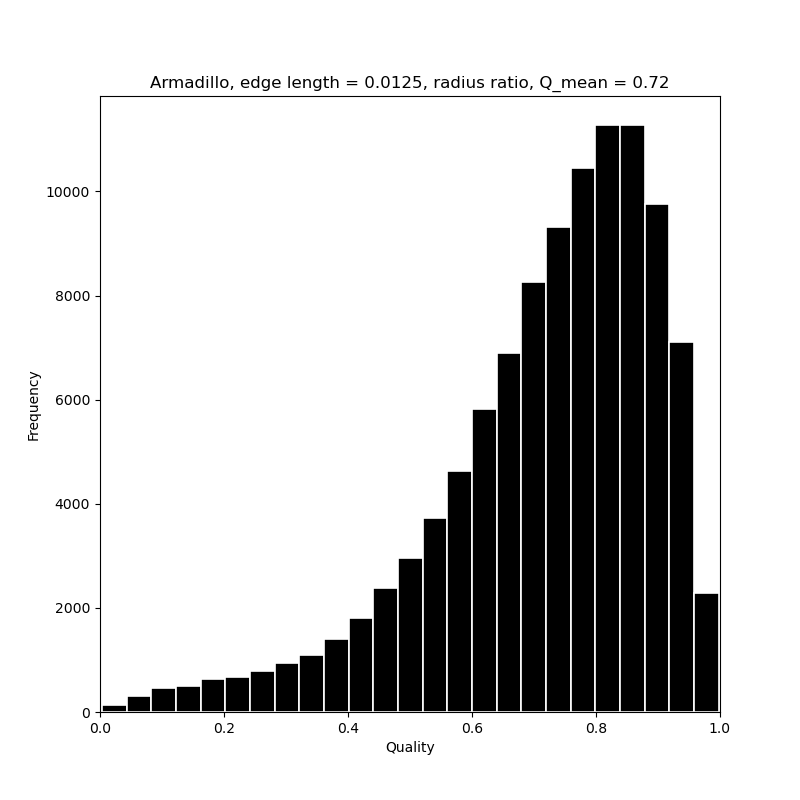

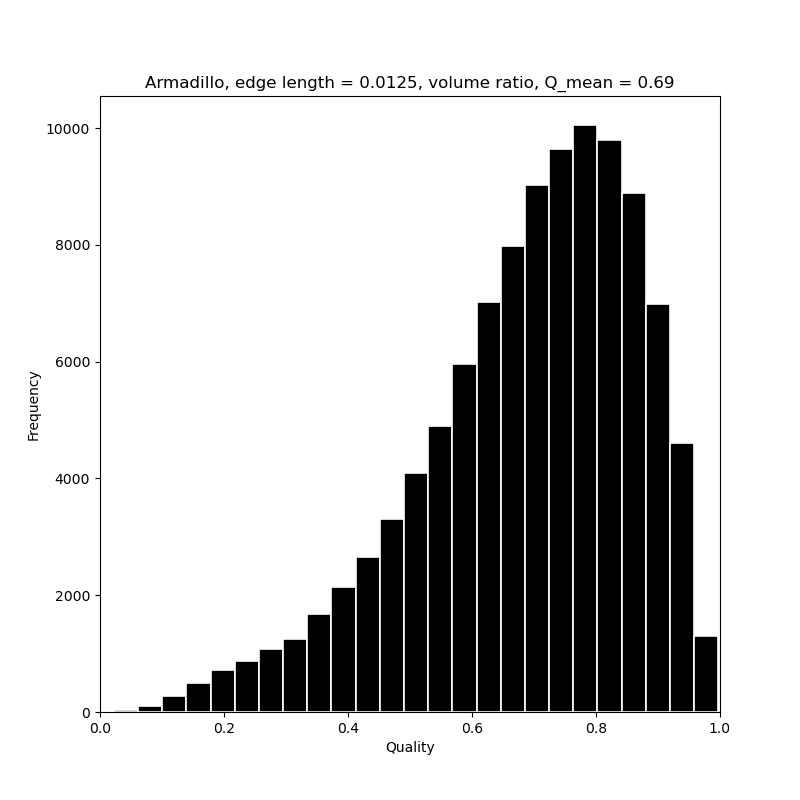

In [52]:
### ARMADILLO MESHES AND QUALITIES ###
if doExp3:
    ls = [0.05, 0.0125]
    for l_edge in ls:
        tetra = wm.Tetrahedralizer(stop_quality=500, edge_length_r = l_edge)
        tetra.load_mesh("armadillo.obj")
        tetra.tetrahedralize()
        V, T = tetra.get_tet_mesh()
        mp.plot(V, T, shading={"wireframe": True}, return_plot=True)
        hfig1, hax1, hist1, Q1 = plot_quality_histograms(V, T, compute_tet_radius_ratio, bins=25)
        hfig2, hax2, hist2, Q2 = plot_quality_histograms(V, T, compute_tet_volume_ratio, bins=25)
        
        title1 = f"Armadillo, edge length = {l_edge}, radius ratio"
        titleQ1 = f"{title1}, Q_mean = {Q1.round(2)}"
        hax1.set_title(titleQ1)
        hax1.set_xlabel("Quality")
        hax1.set_ylabel("Frequency")
        
        title2 = f"Armadillo, edge length = {l_edge}, volume ratio"
        titleQ2 = f"{title2}, Q_mean = {Q2.round(2)}"
        hax2.set_title(titleQ2)
        hax2.set_xlabel("Quality")
        hax2.set_ylabel("Frequency")
        
        if savefigs:
            hfig1.savefig("Images/histograms/" + title1 + ".png", dpi = 300, bbox_inches='tight', pad_inches=0.1)
            hfig2.savefig("Images/histograms/" + title2 + ".png", dpi = 300, bbox_inches='tight', pad_inches=0.1)
        print(f"Finished edge length {l_edge}")